<a href="https://colab.research.google.com/github/abelptvts/keras_music_classifier/blob/master/DL_Music_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Practice - Homework
Team: **BOZGOR**

Member #1: Abel Putovici **E5V8FJ**

Member #1: Zsombor Molnár **FTSI99**

## 🎸🎶 Musical genre classification using Convolutional Neural Networks 🎸🎶
Both of us being huge fans of music, choosing this problem was a natural thing. There are many research papers and articles out there regarding this subject, but most of these approaches try to solve the problem with simple feed-forward neural network with metadata extract from the music, like zero-crossing-rate, tempo, spectral centroid and such. We thought running the spectrograms of music through a convolutional neural network might yield more accurate results (and would be a quite exciting experiment to do 😁)

## 💾 The Dataset 💾
The dataset we found to be the most promising (to say so) is the **GTZAN Genre Collection** dataset. This dataset was used in numerous research papers, such as ***Musical genre classification of audio signals*** by G. Tzanetakis and P. Cook. 

The dataset consists of 10 genres, each consisting of 100 samples with a length of 30 seconds. The genres are the following:


*   **'reggae'** 🌈
*   **'country'** 🤠
*   **'metal'** 🤘
*   **'classical'** 🎻 
*   **'jazz'** 🎺
*   **'rock'** 🎸
*   **'hiphop'** 💿
*   **'disco'** 🕺
*   **'pop'** 🍿
*   **'blues'** 🎸



The most notable drawback of this dataset is that it is quite old (year 2001), therefore a model trained using this might not adapt correctly to let's say the pop music of the 2010's, but... yeah, we'll see. **( ͡° ͜ʖ ͡°)**

## Step 1 - Grab the dataset
The easiest thing to do seemed to be uploading the whole dataset to Google Drive and importing it from there. It turned out to be a breeze, as long as each writer has the right authorization code and access rights set up properly.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
%cd 'My Drive'
%cd 'GTZAN'
%ls -a

/gdrive/My Drive
/gdrive/My Drive/GTZAN
genres/  model.hdf5


Let's see if everything works

In [3]:
import IPython.display as ipd
ipd.Audio('genres/metal/metal.00065.wav')

In [4]:
ipd.Audio('genres/pop/pop.00065.wav')

In [5]:
ipd.Audio('genres/rock/rock.00065.wav')

Time to define a function which grabs each song (with a limit per genre) from dataset, and returns the decoded songs and labels in arrays. 

In [0]:
import os
import librosa
import time
import numpy as np

def load_raw_dataset(basedir, songs_per_genre=-1):
    """
    This function load the raw dataset from the given directory. Te base directory
    must contain the directory of the dataset named 'genres'.

    @param: basedir  the base or containing directory of the dataset
    @param: songs_per_genre  the number of songs to be loaded from each genre
                             (the default value is all)

    @return: the loaded dataset as a directory where the input values' key is 'X'
              and the output values' key is 'Y'
    """
    # first check wheter we are in the correct directory
    if not os.path.isdir(basedir):
        raise Exception("Basedirectory {} is not a directory.".format(basedir))
        
    dirs = os.listdir(basedir)
    if len(dirs) == 0 or dirs[0] != "genres":
        raise Exception("Dataset named 'genres' not found")

    # the list of genres (labels) is basically the list of directory names
    # in the folder
    genres = os.listdir(basedir + dirs[0])
    print('Found {} genres: {}'.format(len(genres), genres))

    X = []
    Y = []
    print("Go have a coffee... Really.\n")

    total_start = time.time()
    for genre in range(len(genres)):
        path = basedir + dirs[0] + '/' + genres[genre]
        print("Loading {}...".format(genres[genre]))

        # the count of loaded songs per genre, needed for limiting the number
        # of loaded songs
        count = 0
        genre_start = time.time()

        for song in os.listdir(path):
            if count == songs_per_genre:
                break

            count += 1

            # librosa takes care of devoding here, we'll load the song in MONO, 
            # and with the standard sample rate of 44100
            loaded, sample_rate = librosa.load(path + '/' + song,
                                               sr=44100,
                                               mono=True
                                              )

            # let's split the sample of 30s into 4 samples of 7.5s
            chunks = np.split(loaded, 4)
            for chunk in chunks:
              sliced = chunk[:330000]
              if len(sliced) != 330000:
                raise Exception("OOOOOPS {}".format(sliced.shape))
              X.append(sliced)
              # print(sliced.shape)
              Y.append(genre)        

        genre_end = time.time()
        print("Loading {} took {} seconds".format(genre,
                                                  genre_end - genre_start
                                                 )
             )
    total_end = time.time()
    print("Total load took {} minutes".format((total_end - total_start) / 60))

    return {'X': X, 'Y': Y}

Load the data finally, with a limit of 5 songs per genre. There should be no limit while training the model. This is only for testing.

In [7]:
raw_data = load_raw_dataset('./', 50)
X_raw = raw_data['X']
Y = raw_data['Y']

Found 10 genres: ['metal', 'classical', 'reggae', 'jazz', 'country', 'rock', 'hiphop', 'disco', 'pop', 'blues']
Go have a coffee... Really.

Loading metal...
Loading 0 took 61.20321083068848 seconds
Loading classical...
Loading 1 took 61.25549340248108 seconds
Loading reggae...
Loading 2 took 62.60833430290222 seconds
Loading jazz...
Loading 3 took 64.63151240348816 seconds
Loading country...
Loading 4 took 65.3147943019867 seconds
Loading rock...
Loading 5 took 66.56187605857849 seconds
Loading hiphop...
Loading 6 took 67.99566698074341 seconds
Loading disco...
Loading 7 took 68.8910083770752 seconds
Loading pop...
Loading 8 took 72.61978721618652 seconds
Loading blues...
Loading 9 took 73.21328353881836 seconds
Total load took 11.071733717123667 minutes


In [8]:
X_raw[:5]

[array([ 0.1504813 ,  0.1920548 ,  0.196797  , ..., -0.13175006,
        -0.17792445, -0.20681904], dtype=float32),
 array([0.42937946, 0.50741595, 0.5704365 , ..., 0.3497824 , 0.3516218 ,
        0.3522952 ], dtype=float32),
 array([ 0.15298659,  0.18076849,  0.20974557, ..., -0.13589346,
        -0.10958404, -0.11053232], dtype=float32),
 array([-0.01604686, -0.05189732, -0.08472253, ...,  0.01093228,
         0.00747815,  0.00450994], dtype=float32),
 array([ 0.01055259,  0.03662182,  0.06516826, ..., -0.14509758,
        -0.12017954, -0.09588103], dtype=float32)]

In [9]:
Y[:5]

[0, 0, 0, 0, 0]

In [0]:
def preprocess(X_raw):
  """
  This function is used to preprocess the dataset and prepare for use.
  
  @param: X_raw  this is the raw dataset's input values
  
  @return: the array of preprocessed data
  """
  X_spect = []
  start = time.time()
  for x in X_raw:
    # spect = librosa.stft(x, )
    spect = librosa.feature.melspectrogram(x)
    spect = librosa.amplitude_to_db(abs(spect))
    X_spect.append(spect)
  end = time.time()
  print("Preprocessing took {} seconds".format(end - start))
  
  return X_spect

In [11]:
X = preprocess(X_raw)
X[0]

Preprocessing took 93.52771878242493 seconds


array([[ 32.53074283,  38.74992488,  43.02373411, ...,  41.74978507,
         43.10435795,  35.69947887],
       [ 34.41888001,  39.7829241 ,  47.53104468, ...,  51.61956447,
         50.33842926,  38.99862814],
       [ 17.8255593 ,  27.59103838,  31.77636309, ...,  41.08140818,
         32.79901256,  29.41233397],
       ...,
       [-11.33200637, -11.33200637, -11.33200637, ..., -11.33200637,
        -11.33200637, -11.33200637],
       [-11.33200637, -11.33200637, -11.33200637, ..., -11.33200637,
        -11.33200637, -11.33200637],
       [-11.33200637, -11.33200637, -11.33200637, ..., -11.33200637,
        -11.33200637, -11.33200637]])

1

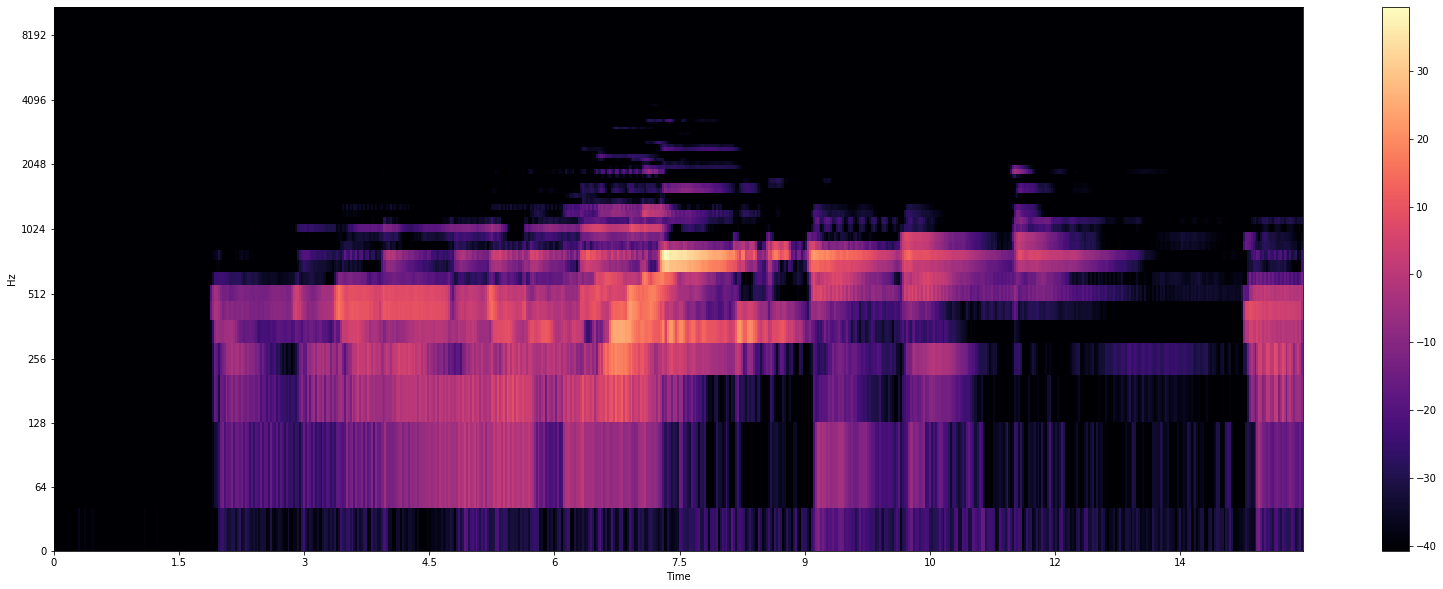

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(28, 10))
librosa.display.specshow(X[200], x_axis="time", y_axis="log")
plt.colorbar()
Y[200]

The raw dataset needs to be split into smaller subsets to use for train and test purposes.

In [0]:
from sklearn.model_selection import train_test_split

def split_dataset(X_original, Y_original,
                  test_size=0.1,
                  random_seed = 666
                 ):
  """
  This function splits the given dataset into train, validation and test data.
  
  @param: X_original  this contains the input values of the dataset
  @param: Y_original  this contains the output values of the dataset
  @param: train_size  this is the size of the train data relative to the dataset
                      (the default value is 0.8)
  @param: valid_size  this is the size of the validation data relative to the dataset
                      (the default value is 0.1)
  @param: random_seed  this is the seed for the data randomizer
                
                       (the default value is 666)
  
  @return: the train, validation and test datasets in dictionary format where the
           input values' key is 'X' and the output values' key is 'Y'
  """
  # creating the train dataset
  X_train, X_test, Y_train, Y_test = train_test_split(X_original, Y_original,
                                                      test_size=test_size,
                                                      random_state=random_seed
                                                      )

  # preparing the return dictionaries
  train_data = {'X': X_train, 'Y': Y_train}
  test_data = {'X': X_test, 'Y': Y_test}
  
  return train_data, test_data


Split the raw dataset into train, validation and test datasets.

In [14]:
train_data, test_data = split_dataset(X, Y)

X = train_data['X']
Y = train_data['Y']

print (X[0].shape)
for i in range(len(X) - 1):
  if X[i].shape != X[i+1].shape:
    print ('oops {}, {}'.format(X[i].shape, X[i+1].shape))

print(Y)


(128, 645)
[6, 0, 9, 5, 5, 0, 8, 1, 0, 5, 9, 8, 6, 7, 1, 4, 2, 7, 4, 0, 9, 6, 3, 8, 3, 8, 3, 5, 2, 5, 3, 9, 8, 7, 7, 5, 7, 5, 3, 0, 2, 0, 9, 8, 1, 4, 5, 1, 4, 4, 7, 6, 2, 3, 3, 4, 5, 3, 2, 5, 8, 6, 7, 1, 8, 5, 0, 0, 4, 6, 9, 1, 7, 8, 6, 2, 2, 1, 8, 0, 0, 6, 6, 9, 1, 9, 3, 4, 3, 8, 6, 5, 4, 9, 1, 5, 2, 3, 1, 4, 0, 1, 8, 2, 3, 6, 1, 8, 6, 4, 9, 1, 0, 5, 0, 5, 5, 9, 9, 4, 9, 0, 0, 6, 1, 9, 7, 5, 1, 3, 8, 8, 2, 8, 4, 8, 9, 4, 3, 3, 3, 2, 8, 8, 7, 0, 4, 4, 6, 1, 8, 6, 0, 3, 6, 3, 4, 9, 2, 9, 5, 6, 8, 3, 8, 6, 5, 4, 6, 2, 5, 4, 5, 3, 8, 9, 1, 2, 2, 9, 4, 4, 0, 4, 0, 5, 8, 7, 9, 1, 2, 9, 4, 0, 1, 1, 6, 2, 3, 5, 0, 2, 7, 1, 4, 2, 6, 0, 4, 7, 5, 8, 8, 5, 0, 7, 9, 2, 5, 2, 8, 6, 9, 7, 0, 1, 5, 0, 8, 9, 8, 0, 5, 6, 3, 0, 0, 7, 7, 0, 8, 6, 4, 8, 2, 2, 0, 4, 9, 4, 7, 2, 8, 8, 9, 7, 2, 3, 7, 1, 7, 7, 5, 7, 8, 4, 3, 0, 3, 8, 1, 6, 4, 7, 3, 7, 3, 4, 3, 1, 4, 4, 7, 0, 6, 3, 7, 6, 8, 4, 3, 1, 9, 8, 8, 1, 7, 7, 5, 8, 0, 6, 2, 6, 7, 0, 1, 8, 7, 6, 5, 4, 0, 7, 2, 4, 7, 1, 2, 6, 1, 9, 5, 2, 8, 1, 3, 3, 2, 4

In [15]:
#önyvtárak betöltése
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, kernel_size=(128, 5), activation='tanh', input_shape=(128, 645, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 4)))

model.add(Conv2D(32, kernel_size=(1, 5), activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 4)))

model.add(Conv2D(64, kernel_size=(1, 5), activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 4)))

model.add(Flatten())
model.add(Dense(1024, 
                activation="tanh", 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))
)
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

print (model.summary())

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 641, 32)        20512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 641, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 160, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 156, 32)        5152      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 156, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 39, 32)         0   

In [16]:
#cost függvényünk a categoriucal crossentrophy lesz. Slide 19
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
adam = Adam(lr=0.0008)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [0]:
#Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping, ModelCheckpoint
patience = 50
early_stopping = EarlyStopping(patience=patience)
checkpointer = ModelCheckpoint(filepath="model.hdf5", save_best_only=True, verbose=1)

In [18]:
X = np.array(X, dtype=float)
print(X.shape)
X = X.reshape((len(X), 128, 645, 1))
Y = np.array(Y);
print(Y.shape)
print(X.shape)
network_history = model.fit(X, Y, 
                            batch_size=5,
                            epochs=250,
                            verbose=1,
                            validation_split=0.1,
                            callbacks=[early_stopping, checkpointer]
                            )

(1800, 128, 645)
(1800,)
(1800, 128, 645, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1620 samples, validate on 180 samples
Epoch 1/250
1620/1620 [==============================] - 9s 5ms/step - loss: 14.0022 - acc: 0.1438 - val_loss: 7.8097 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 7.80975, saving model to model.hdf5
Epoch 2/250
1620/1620 [==============================] - 3s 2ms/step - loss: 3.7426 - acc: 0.1216 - val_loss: 36.0111 - val_acc: 0.1278

Epoch 00002: val_loss did not improve from 7.80975
Epoch 3/250
1620/1620 [==============================] - 4s 2ms/step - loss: 2.5372 - acc: 0.1086 - val_loss: 2.8916 - val_acc: 0.0944

Epoch 00003: val_loss improved from 7.80975 to 2.89157, saving model to model.hdf5
Epoch 4/250
1620/1620 [==============================] - 3s 2ms/step - loss: 2.4447 - acc: 0.1272 - val_loss: 2.3893 - val_acc: 0.0833

Epoch 00004: val_loss improved from 2.89157 to 2.3892

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


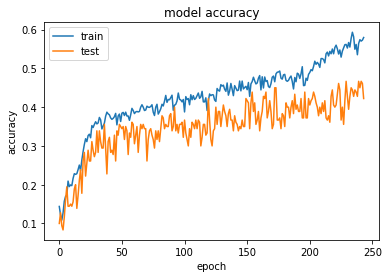

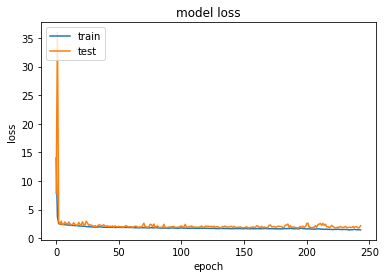

In [23]:
print(network_history.history.keys())

# summarize history for accuracy
plt.plot(network_history.history['acc'])
plt.plot(network_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(network_history.history['loss'])
plt.plot(network_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import load_model

model = load_model('model.hdf5')

In [21]:
X_test = np.array(test_data['X']).reshape((-1, 128, 645, 1))
Y_test = np.array(test_data['Y'])
predictions = model.predict(X_test)
classes = np.array([])

for pred in predictions:
  classes = np.append(classes, pred[pred.argmax()])
print(predictions[13])
print(predictions[13].argmax())

classes = classes.round()
print(classes[13])

[0.02115684 0.04524642 0.02228132 0.21053687 0.23584501 0.20066586
 0.01644833 0.08741882 0.01412381 0.14627674]
4
0.0


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(classes, Y_test))
# print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
# print(classification_report(predictions, Y_test, target_names=target_names))


Confusion Matrix
[[ 4 11  7 12 15 16 12 23 16 10]
 [10 16 16  7  2  3  8  0  8  4]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
